This notebook is the second of 2 parts for the analysis of mouse data presented in **Figure 6**. This notebook ingests the location of nucleosomes (from DANPOS dpos, filtered and converted by `danpos-xls-process.py`), the nucleosome positioning track (from DANPOS dpos, pre-processed by the somewhat misnamed `wig2rle.R`), and PF binding sites (processed from FIMO results via `py3-motif-matching.ipynb`), and outputs the final figures (though the file-writing cells have been disabled).

**Warning** - this notebook requires significant computational resources and was originally run on a compute node of the Rockefeller High-Performance Computing environment. You should have at least 10 GB of RAM *available to the R kernel* (not just on the machine, as other programs will require their own memory) - most laptops will not have this much memory. I have observed my notebooks' memory usage peaking at as much as 80 GB of RAM (!).

I suspect that the main culprit is the `strandedDistanceByNearest` call. I welcome suggestions to improve its decidedly inefficient iterative algorithmic structure, which was regrettably necessary to handle NAs.

# various initialization steps

In [1]:
# for my sanity - map some function names that I think exist to what actually exist
nrows <- nrow
ncols <- ncol
len <- length

In [2]:
options(repr.plot.width=12, repr.plot.height=4)

In [3]:
multiplot <- function(..., plotlist=NULL, cols) {
    # from Winston Chang's R Cookbook
    
    require(grid)

    # Make a list from the ... arguments and plotlist
    plots <- c(list(...), plotlist)

    numPlots = length(plots)

    # Make the panel
    plotCols = cols                          # Number of columns of plots
    plotRows = ceiling(numPlots/plotCols) # Number of rows needed, calculated from # of cols

    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(plotRows, plotCols)))
    vplayout <- function(x, y)
        viewport(layout.pos.row = x, layout.pos.col = y)

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
        curRow = ceiling(i/plotCols)
        curCol = (i-1) %% plotCols + 1
        print(plots[[i]], vp = vplayout(curRow, curCol ))
    }

}

In [4]:
library(extrafont)

Registering fonts with R


In [5]:
#library(tracktables)
library(rtracklayer)
library(HelloRanges)
library(BSgenome.Mmusculus.UCSC.mm9)
library(heatmaps)
library(ggplot2)

library(TxDb.Mmusculus.UCSC.mm9.knownGene)

Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min

Loading requi

In [6]:
library(viridis)

Loading required package: viridisLite


In [7]:
mouse_transcripts <- transcripts(TxDb.Mmusculus.UCSC.mm9.knownGene, columns=c("tx_id", "tx_name"))
mouse_transcripts <- keepStandardChromosomes(mouse_transcripts, pruning.mode = 'tidy')
# drop MT
mouse_transcripts <- mouse_transcripts[seqnames(mouse_transcripts) != "chrM"]
mouse_tss <- resize(mouse_transcripts, width=1, fix='start')

In [8]:
mm9info <- seqinfo(BSgenome.Mmusculus.UCSC.mm9)

In [9]:
mouse_tss_2000 <- resize(mouse_tss, width = 2000, fix='center')
mouse_tss_2000 <- trim(mouse_tss_2000)

# Whyte 2013 ChipSeq motifs

I generated peaks via MACS2 from data in Whyte 2013.

## load motif locations into bioconductor

general formula: genomic coordinate of a motif's start = genomic coordinate of a motif's peak window + FIMO-reported start coordinate - value of flanking DNA bp (generally 200) - 1 (due to 1-based indexing, likely in FIMO)

In [10]:
## from the py3 notebook "py3_motif-matching"

Whyte_motifs <- import("~/SoxOct/mouse/chipseq_Whyte2013/Sox-Oct_motifs.bed")
Whyte_outermotifs <- import("~/SoxOct/mouse/chipseq_Whyte2013/Sox-Oct_outermotifs.bed")
Whyte_Soxmotifs <- import("~/SoxOct/mouse/chipseq_Whyte2013/Sox_motifs.bed")
Whyte_Octmotifs <- import("~/SoxOct/mouse/chipseq_Whyte2013/Oct_motifs.bed")

Whyte_tandemmotifs <- import("~/SoxOct/mouse/chipseq_Whyte2013/tandem_motifs.bed")

In [11]:
## from the py3 notebook "py3_motif-matching"

EpiSC_motifs <- import("~/SoxOct/mouse/EpiSC_chip/Sox-Oct_motifs.bed")
EpiSC_outermotifs <- import("~/SoxOct/mouse/EpiSC_chip/Sox-Oct_outermotifs.bed")
EpiSC_Soxmotifs <- import("~/SoxOct/mouse/EpiSC_chip/Sox_motifs.bed")
EpiSC_Octmotifs <- import("~/SoxOct/mouse/EpiSC_chip/Oct_motifs.bed")

EpiSC_tandemmotifs <- import("~/SoxOct/mouse/EpiSC_chip/tandem_motifs.bed")

## define colors

In [12]:
safered <- "#920000"
safegreen <- "#009292"
safeviolet <- "#490092"

## define metametaplot

In [13]:
getvalues <- function(granges, width = 2000, track){
    motifwindow <- resize(granges, width = width, fix = 'center')
    
    htmap <- CoverageHeatmap(windows = motifwindow, track = track)
    
    plotdata <- colMeans(image(htmap))
    plotaxis <- 1:len(plotdata) - floor(width/2)
    df <- data.frame(x = plotaxis, y= plotdata)
    
    return (df)
}

In [14]:
Whyte_metametaplot <- function(track, mwidth, title=""){
    
    df1 <- getvalues(Whyte_Soxmotifs, width=mwidth, track=track)
    df2 <- getvalues(Whyte_Octmotifs, width=mwidth, track=track)
    #df3 <- getvalues(Whyte_outermotifs, width=mwidth, track=track)
    df3 <- getvalues(Whyte_tandemmotifs, width=mwidth, track=track)
    #df4 <- getvalues(Soxmotifs, width=2000, track=track)
    
    #options(repr.plot.width=3, repr.plot.height=1)
    
    abs <- floor(mwidth/2)
    plt <- ggplot() + 
            geom_line(data = df1, aes(x = x, y = y, colour = "Sox2"), size=.8) +
            geom_line(data = df2, aes(x = x, y = y, colour = "Oct4"), size=.8) +
            geom_line(data = df3, aes(x = x, y = y, colour = "Oct4Sox2"), size=.8) +
            #geom_line(data = df4, aes(x = x, y = y, colour = "TSS")) +
            scale_colour_manual(values=c(safegreen, safeviolet,safered), name=title) +
            theme_classic() +
            ylab("Average\nnucleosome occupancy") +
            xlab("Relative genomic position (bp)") +
            theme(axis.title.x=element_text(size=rel(0.9))) +
            theme(axis.title.y=element_text(size=rel(0.9))) +
            theme(title=element_text(size=rel(0.8))) +
            #ylim (40,90) +
            #ylim(40,60) +
            xlim(-abs, abs) +
            scale_x_continuous(minor_breaks = seq(-1029,1029, 147))
                       
    plt
    
    #options(repr.plot.width=3, repr.plot.height=3)
    
    return(plt)
}

In [15]:
EpiSC_metametaplot <- function(track, mwidth, title=""){
    
    df1 <- getvalues(EpiSC_Soxmotifs, width=mwidth, track=track)
    df2 <- getvalues(EpiSC_Octmotifs, width=mwidth, track=track)
    #df3 <- getvalues(Whyte_outermotifs, width=mwidth, track=track)
    df3 <- getvalues(EpiSC_tandemmotifs, width=mwidth, track=track)
    #df4 <- getvalues(Soxmotifs, width=2000, track=track)
    
    #options(repr.plot.width=3, repr.plot.height=1)
    
    abs <- floor(mwidth/2)
    plt <- ggplot() + 
            geom_line(data = df1, aes(x = x, y = y, colour = "Sox2"), size=.8) +
            geom_line(data = df2, aes(x = x, y = y, colour = "Oct4"), size=.8) +
            geom_line(data = df3, aes(x = x, y = y, colour = "Oct4Sox2"), size=.8) +
            #geom_line(data = df4, aes(x = x, y = y, colour = "TSS")) +
            scale_colour_manual(values=c(safegreen, safeviolet,safered), name=title) +
            theme_classic() +
            ylab("Average\nnucleosome occupancy") +
            xlab("Relative genomic position (bp)") +
            theme(axis.title.x=element_text(size=rel(0.9))) +
            theme(axis.title.y=element_text(size=rel(0.9))) +
            theme(title=element_text(size=rel(0.8))) +
            #ylim (40,90) +
            #ylim(40,60) +
            xlim(-abs, abs) +
            scale_x_continuous(minor_breaks = seq(-1029,1029, 147))
                       
    plt
    
    #options(repr.plot.width=3, repr.plot.height=3)
    
    return(plt)
}

# load Teif MNase-seq data

## nucleosome track

In [16]:
mm_npos_p <- readRDS("~/SoxOct/danpos-res/pooled/mESC-MNAseseq.smooth.rle.RDS")

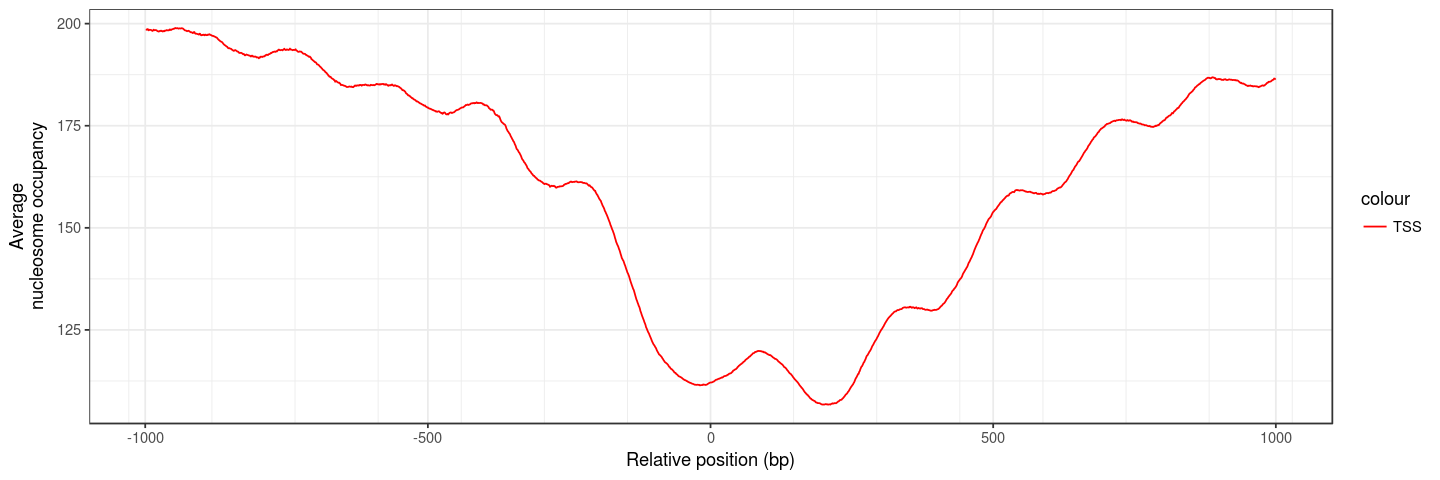

In [17]:
htmap_mm_tss_mnase <- CoverageHeatmap(windows = trim(mouse_tss_2000), track = mm_npos_p)

plotdata <- colMeans(image(htmap_mm_tss_mnase))
plotaxis <- 1:len(plotdata) - 1000
pltdf_mm_tss_mnase <- data.frame(x = plotaxis, y= plotdata)

plt <- ggplot() + 
    geom_line(data = pltdf_mm_tss_mnase, aes(x = x, y = y, colour = "TSS")) +
    #geom_line(data = pltdf4, aes(x = x, y = y, colour = "TSS")) +
    scale_colour_manual(values=c("red")) +
    #theme_classic() +
    theme_bw() +
    ylab("Average\nnucleosome occupancy") +
    xlab("Relative position (bp)") +
    #ylim (40,90) +
    #ylim(40,60) +
    #xlim(-200,200) +
    scale_x_continuous(minor_breaks = seq(-1029,1029, 147))

options(repr.plot.width=12, repr.plot.height=4)

plt

## nucleosome locations

In [18]:
# pooled

# read in the ranges
npeaks_m1_p <- import("~/SoxOct/danpos-res/pooled/mESC-MNaseseq.smooth.positions.bedgraph")

# resize the nucleosome peaks (DANPOS hard-codes them to be 140 bp)
npeaks_m1_p_c <- resize(npeaks_m1_p, width = 0, fix = "center")

# Figure 6B: aggregate nucleosome score

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


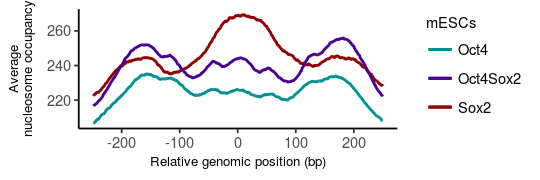

In [19]:
options(repr.plot.width=4.5, repr.plot.height=1.5)
Whyte_metametaplot(track = mm_npos_p, mwidth = 500, title="mESCs")

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


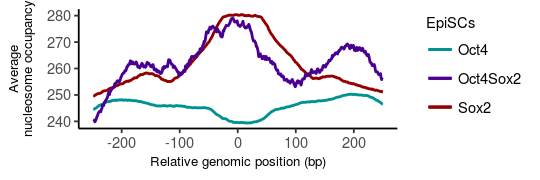

In [20]:
options(repr.plot.width=4.5, repr.plot.height=1.5)
EpiSC_metametaplot(track = mm_npos_p, mwidth = 500, title="EpiSCs")
#ggsave(filename = "PanelB-2.eps", width = 4.5, height = 1.5, units = "in")

# calculate distributions of distances

In [22]:
# resize the motif tracks to be tiny
Whyte_motifs_c      <- resize(Whyte_motifs,      width = 0, fix='center')
Whyte_outermotifs_c <- resize(Whyte_outermotifs, width = 0, fix='center')
Whyte_Soxmotifs_c   <- resize(Whyte_Soxmotifs,   width = 0, fix='center')
Whyte_Octmotifs_c   <- resize(Whyte_Octmotifs,   width = 0, fix='center')

Whyte_tandemmotifs_c <- resize(Whyte_tandemmotifs, width=0, fix='center')

## stranded Distance

### strandedDistanceByNearest function definition

In [24]:
strandedDistanceByNearest <- function(query, target){
    # gets (non absolute) distance for each item in query on target
    
    # calculate the distance:
    
    ## note that precede actually returns the item in subject that the target PRECEDES, not the other way around!
    #d_precede <- distance((target)[precede(subject = target, x = query)], query)
    ## you'd think the above would work, but annoyingly sometimes you get an NA, and then the subsetting dies...
    idx_precede <- precede(subject = target, x = query)
    d_precede <- integer(length(query))
    for (i in 1:length(query)){
        index <- idx_precede[i]
        
        if (is.na(index)){
            assign <- NA
        } else {
            assign <- distance(target[index],query[i])
        }
        
        d_precede[i] <- assign
    }
    
    ## the same goes for follow; the negation is so we correctly have negative distances
    #d_follow  <- -distance((target)[follow(subject = target, x = query)], query)
    
    idx_follow <- follow(subject = target, x = query)
    d_follow <- integer(length(query))
    for (i in 1:length(query)){
        index <- idx_follow[i]
        
        if (is.na(index)){
            assign <- NA
        } else {
            assign <- -distance(target[index],query[i]) # note that here is the negation!
        }
        
        d_follow[i] <- assign
    }
    
    # compare precede vs. follow
    # return the one with the biggest abs
    # if one of them is null, the other wins by default; if both are null, return NA
    # note that this is tremendously inelegant and likely to be slow!!!
    
    answer <- integer(length(query)) # pre-allocate a vector to make this less bad
    for (i in 1:length(query)){
        
        
        if (is.na(d_precede[i]) & !is.na(d_follow[i])){
        # only the follow number is valid
            select <- d_follow[i]
        } else if (!is.na(d_precede[i]) & is.na(d_follow[i])){
        # only the precede is valid
            select <- d_precede[i]
        } else if (is.na(d_precede[i]) & is.na(d_follow[i])){
        # somehow both are invalid??
            select <- NA
        } else {
        # both are presumably valid now
            if (abs(d_follow[i]) < d_precede[i]) {
                select <- d_follow[i]
            } else select <- d_precede[i]
            
        }
        answer[i] <- select
    }
    
    return (answer)
}

In [25]:
strandeddens <- function(data, filter = 150, bw = 2, color = "orchid4", linetype="solid"){
    
    df <- data.frame(x=data)
    df <- data.frame(x=df[abs(df$x) <= filter,])
    
    plt <- ggplot() +
            #geom_histogram(df, aes(x=x, y=stat(density)), binwidth=1, fill = 'gray') +
            stat_density(data = df, aes(x=x), bw=bw, color = color, geom = 'line', linetype=linetype, size=.8)  +
            theme_classic()                                    +
            geom_vline(xintercept=73, linetype='dotted')  +
            geom_vline(xintercept=-73, linetype='dotted') + 
            coord_cartesian(ylim = c(0,.006)) + 
            xlab("Relative position (bp)") +
            geom_vline(xintercept=0, linetype='dashed') +
            theme(axis.title.x=element_text(size=rel(0.9))) +
            theme(axis.title.y=element_text(size=rel(0.9))) +
            theme(title=element_text(size=rel(0.75))) + 
            theme(text = element_text(family = 'Arial'))

    plt 
    
    return (plt)
}

In [26]:
Whyte_std_outermotifs <- import("~/SoxOct/mouse/chipseq_Whyte2013/Sox-Oct_outermotifs.strand.bed")
Whyte_std_outermotifs_c <- resize(Whyte_std_outermotifs, width=0, fix='center')

Whyte_std_tandemmotifs <- import("~/SoxOct/mouse/chipseq_Whyte2013/tandemmotifs.strand.bed")
Whyte_std_tandemmotifs_c <- resize(Whyte_std_tandemmotifs, width=0, fix='center')

Whyte_std_Soxmotifs <- import("~/SoxOct/mouse/chipseq_Whyte2013/Sox_motifs.strand.bed")
Whyte_std_Soxmotifs_c <- resize(Whyte_std_Soxmotifs, width=0, fix='center')

Whyte_std_Octmotifs <- import("~/SoxOct/mouse/chipseq_Whyte2013/Oct_motifs.strand.bed")
Whyte_std_Octmotifs_c <- resize(Whyte_std_Octmotifs, width=0, fix='center')

In [27]:
EpiSC_std_outermotifs <- import("~/SoxOct/mouse/EpiSC_chip/Sox-Oct_outermotifs.strand.bed")
EpiSC_std_outermotifs_c <- resize(EpiSC_std_outermotifs, width=0, fix='center')

EpiSC_std_tandemmotifs <- import("~/SoxOct/mouse/EpiSC_chip/tandemmotifs.strand.bed")
EpiSC_std_tandemmotifs_c <- resize(EpiSC_std_tandemmotifs, width=0, fix='center')

EpiSC_std_Soxmotifs <- import("~/SoxOct/mouse/EpiSC_chip/Sox_motifs.strand.bed")
EpiSC_std_Soxmotifs_c <- resize(EpiSC_std_Soxmotifs, width=0, fix='center')

EpiSC_std_Octmotifs <- import("~/SoxOct/mouse/EpiSC_chip/Oct_motifs.strand.bed")
EpiSC_std_Octmotifs_c <- resize(EpiSC_std_Octmotifs, width=0, fix='center')

### Figure 6C, panel 2

**warning** -- the `strandedDistanceByNearest` function is quite slow - expect this to take a while. Maybe go get a cup of coffee and check your email.

In [29]:
dist_strand_m1_p     <- strandedDistanceByNearest(target = npeaks_m1_p_c, query = Whyte_std_tandemmotifs_c)
dist_strand_m1_p_Sox <- strandedDistanceByNearest(target = npeaks_m1_p_c, query = Whyte_std_Soxmotifs_c)
dist_strand_m1_p_Oct <- strandedDistanceByNearest(target = npeaks_m1_p_c, query = Whyte_std_Octmotifs_c)

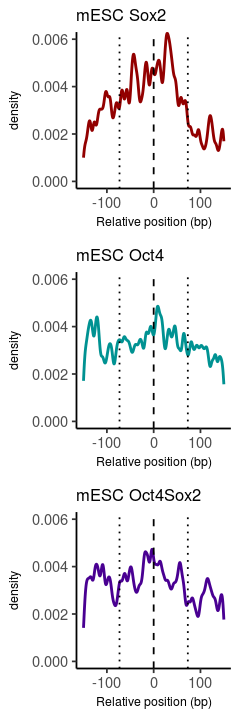

In [32]:
plt1 <- strandeddens(dist_strand_m1_p,     filter = 150, bw =3, color=safeviolet)+ ggtitle('mESC Oct4Sox2')
plt2 <- strandeddens(dist_strand_m1_p_Sox, filter = 150, bw =3, color=safered   ) +ggtitle('mESC Sox2') 
plt3 <- strandeddens(dist_strand_m1_p_Oct, filter = 150, bw =3, color=safegreen ) +ggtitle('mESC Oct4')# +xlab("Relative position (bp)")

options(repr.plot.width=2, repr.plot.height=6)
#options(repr.plot.width=6, repr.plot.height=2)
multiplot( plt2, plt3,plt1, cols = 1)

### Figure 6C, panel 1

**warning** -- the `strandedDistanceByNearest` function is quite slow - expect this to take a while. Maybe go get a cup of coffee and check your email.

In [30]:
dist_Epi_strand_m1_p_tandem  <- strandedDistanceByNearest(target = npeaks_m1_p_c, query = EpiSC_std_tandemmotifs_c)
dist_Epi_strand_m1_p_Sox     <- strandedDistanceByNearest(target = npeaks_m1_p_c, query = EpiSC_std_Soxmotifs_c)
dist_Epi_strand_m1_p_Oct     <- strandedDistanceByNearest(target = npeaks_m1_p_c, query = EpiSC_std_Octmotifs_c)

Loading required package: grid


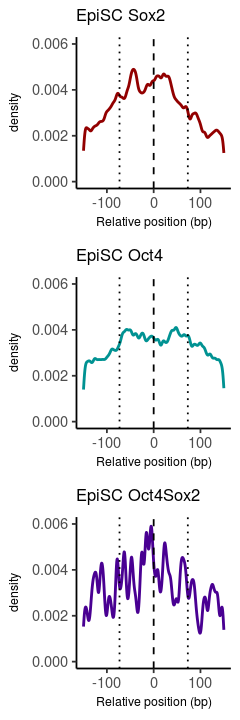

In [31]:
plt1 <- strandeddens(dist_Epi_strand_m1_p_tandem,     filter = 150, bw =3, color=safeviolet)+ ggtitle('EpiSC Oct4Sox2')
plt2 <- strandeddens(dist_Epi_strand_m1_p_Sox, filter = 150, bw =3, color=safered   ) +ggtitle('EpiSC Sox2') 
plt3 <- strandeddens(dist_Epi_strand_m1_p_Oct, filter = 150, bw =3, color=safegreen ) +ggtitle('EpiSC Oct4')# +xlab("Relative position (bp)")

options(repr.plot.width=2, repr.plot.height=6)
#options(repr.plot.width=6, repr.plot.height=2)
multiplot( plt2, plt3,plt1, cols = 1)

# Stats

## KS wrapper

In [33]:
library(Matching)

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:VariantAnnotation’:

    select

The following object is masked from ‘package:AnnotationDbi’:

    select

## 
##  Matching (Version 4.9-3, Build Date: 2018-05-03)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##



In [34]:
KSwrap <- function(x, y, filter){
    
    df1 = data.frame(x=x)
    df1 = df1[abs(df1$x) <= filter,]
    print(len(df1))
    
    df2 = data.frame(x=y)
    df2 = df2[abs(df2$x) <= filter,]
    print(len(df2))

    ks.boot(Tr = df1, Co = df2, alternative = "two.sided", nboots = 10000)
}

KSwrapunif <- function(x, filter){
    
    df1 = data.frame(x=x)
    df1 = df1[abs(df1$x) <= filter,]
    print(len(df1))
    
    ks.test(x = df1, y = "punif", min= -filter, max=filter,  alternative = "two.sided")

}

## KS tests between distributions

note that since I use a bootstrapped version of the Kolmogorov-Smirnov test, the numbers generated will not be deterministic.

### KS in mESCs, 300 bp window

In [838]:
summary(KSwrap(dist_strand_m1_p_Oct, dist_strand_m1_p_Sox, filter =150))
print("Oct<--->Sox")
print("============\\n\\n")
summary(KSwrap(dist_strand_m1_p_Oct, dist_strand_m1_p, filter =150))
print("Oct<--->tandem")
print("============\\n\\n")
summary(KSwrap(dist_strand_m1_p_Sox, dist_strand_m1_p, filter =150))
print("Sox<--->tandem")
print("============\\n\\n")

[1] 2437
[1] 1579

Bootstrap p-value:     1e-04 
Naive p-value:         2.6626e-05 
Full Sample Statistic: 0.07654 

[1] "Oct<--->Sox"
[1] "============\\n\\n"
[1] 2437
[1] 2581

Bootstrap p-value:     0.1401 
Naive p-value:         0.1608 
Full Sample Statistic: 0.031706 

[1] "Oct<--->tandem"
[1] "============\\n\\n"
[1] 1579
[1] 2581

Bootstrap p-value:     0.002 
Naive p-value:         0.0028771 
Full Sample Statistic: 0.057793 

[1] "Sox<--->tandem"
[1] "============\\n\\n"


### KS in mEpiSCs, 300 bp window

In [828]:
summary(KSwrap(dist_Epi_strand_m1_p_Oct, dist_Epi_strand_m1_p_Sox, filter =150))
print("Oct<--->Sox")
print("============\\n\\n")
summary(KSwrap(dist_Epi_strand_m1_p_Oct, dist_strand_m1_p, filter =150))
print("Oct<--->tandem")
print("============\\n\\n")
summary(KSwrap(dist_Epi_strand_m1_p_Sox, dist_strand_m1_p, filter =150))
print("Sox<--->tandem")
print("============\\n\\n")

[1] 21050
[1] 14235

Bootstrap p-value:     < 2.22e-16 
Naive p-value:         0 
Full Sample Statistic: 0.06802 

[1] "Oct<--->Sox"
[1] "============\\n\\n"
[1] 21050
[1] 2581

Bootstrap p-value:     < 2.22e-16 
Naive p-value:         3.2446e-06 
Full Sample Statistic: 0.053845 

[1] "Oct<--->tandem"
[1] "============\\n\\n"
[1] 14235
[1] 2581

Bootstrap p-value:     < 2.22e-16 
Naive p-value:         7.9887e-07 
Full Sample Statistic: 0.058066 

[1] "Sox<--->tandem"
[1] "============\\n\\n"


## KS tests against uniform distribution

### in mESCs on 300 bp window

In [53]:
# mESCs

print("Oct<--->null")
KSwrapunif(dist_strand_m1_p_Oct, filter =150)
print("OctSox<--->null")
KSwrapunif(dist_strand_m1_p, filter =150)
print("Sox<--->null")
KSwrapunif(dist_strand_m1_p_Sox, filter =150)

[1] "Oct<--->null"
[1] 2437


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
“ties should not be present for the Kolmogorov-Smirnov test”


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.0384, p-value = 0.001513
alternative hypothesis: two-sided


[1] "OctSox<--->null"
[1] 2581


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
“ties should not be present for the Kolmogorov-Smirnov test”


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.058073, p-value = 5.502e-08
alternative hypothesis: two-sided


[1] "Sox<--->null"
[1] 1579


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
“ties should not be present for the Kolmogorov-Smirnov test”


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.10891, p-value < 2.2e-16
alternative hypothesis: two-sided


### in mEpiSCs on 300 bp window

In [52]:
# EpiSCs @ 150 bp
print("Oct<--->null")
KSwrapunif(dist_Epi_strand_m1_p_Oct, filter =150)
print("OctSox<--->null")
KSwrapunif(dist_Epi_strand_m1_p_tandem, filter =150)
print("Sox<--->null")
KSwrapunif(dist_Epi_strand_m1_p_Sox, filter =150)

[1] "Oct<--->null"
[1] 21050


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
“ties should not be present for the Kolmogorov-Smirnov test”


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.040982, p-value < 2.2e-16
alternative hypothesis: two-sided


[1] "OctSox<--->null"
[1] 432


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
“ties should not be present for the Kolmogorov-Smirnov test”


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.059352, p-value = 0.09532
alternative hypothesis: two-sided


[1] "Sox<--->null"
[1] 14235


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
“ties should not be present for the Kolmogorov-Smirnov test”


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.075813, p-value < 2.2e-16
alternative hypothesis: two-sided


### in mESCs on 146bp window (nucleosome)

In [40]:
# mESCs

print("Oct<--->null")
KSwrapunif(dist_strand_m1_p_Oct, filter =73)
print("OctSox<--->null")
KSwrapunif(dist_strand_m1_p, filter =73)
print("Sox<--->null")
KSwrapunif(dist_strand_m1_p_Sox, filter =73)

[1] "Oct<--->null"
[1] 1269


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
“ties should not be present for the Kolmogorov-Smirnov test”


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.035742, p-value = 0.07815
alternative hypothesis: two-sided


[1] "OctSox<--->null"
[1] 1384


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
“ties should not be present for the Kolmogorov-Smirnov test”


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.035385, p-value = 0.0625
alternative hypothesis: two-sided


[1] "Sox<--->null"
[1] 995


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
“ties should not be present for the Kolmogorov-Smirnov test”


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.044304, p-value = 0.04024
alternative hypothesis: two-sided


### in mEpiSCs on 146bp window (nucleosome)

In [45]:
# EpiSCs @ 73 bp

print("Oct<--->null")
KSwrapunif(dist_Epi_strand_m1_p_Oct, filter =73)
print("OctSox<--->null")
KSwrapunif(dist_Epi_strand_m1_p_tandem, filter =73)
print("Sox<--->null")
KSwrapunif(dist_Epi_strand_m1_p_Sox, filter =73)

[1] "Oct<--->null"
[1] 11542


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
“ties should not be present for the Kolmogorov-Smirnov test”


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.015319, p-value = 0.008881
alternative hypothesis: two-sided


[1] "OctSox<--->null"
[1] 245


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
“ties should not be present for the Kolmogorov-Smirnov test”


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.045541, p-value = 0.6898
alternative hypothesis: two-sided


[1] "Sox<--->null"
[1] 8548


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
“ties should not be present for the Kolmogorov-Smirnov test”


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.039785, p-value = 3.539e-12
alternative hypothesis: two-sided
